In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define file paths
abundance_file = 'data/rnaseq_abundance.csv'
counts_file = 'data/rnaseq_counts.csv'
length_file = 'data/rnaseq_length.csv'

# Load data
abundance_data = pd.read_csv(abundance_file, index_col=0)
counts_data = pd.read_csv(counts_file, index_col=0)
length_data = pd.read_csv(length_file, index_col=0)

## Normalize the counts to TPMs
1 - Calculate RPK (Reads Per Kilobase): Divide the counts by the gene length (in kilobases).

3 - Calculate the Scaling Factor: Sum up the RPK values for each sample to get a total RPK value.

4 - Normalize to TPM: Divide each gene's RPK by the total RPK for the respective sample, then multiply by 

In [3]:
# Define a function to normalize counts to TPMs
def normalize_to_tpm(counts_df, lengths_df):
    # Step 1: Calculate RPK
    lengths_kb = lengths_df / 1000  # Convert lengths to kilobases
    rpk = counts_df.div(lengths_kb)

    # Step 2: Calculate scaling factors (sum of RPKs for each sample)
    scaling_factors = rpk.sum(axis=0)

    # Step 3: Normalize to TPM
    tpm = rpk.div(scaling_factors) * 1e6

    return tpm

# Perform normalization
tpm_data = normalize_to_tpm(counts_data, length_data)

## Load protein yield data and combine with rna_seq

In [4]:
# Load protein yield data
protein_yield_data = pd.read_csv('data/supplementary_data_1.csv')

# Ensure 'Total.purified.protein_stock1.stock2_microg' is float and fill NaN with 0
protein_yield_data['Total.purified.protein_stock1.stock2_microg'] = pd.to_numeric(
    protein_yield_data['Total.purified.protein_stock1.stock2_microg'], errors='coerce'
).fillna(0)

# Select relevant columns from the protein yield data
protein_yield = protein_yield_data[['sample_ID', 'Total.purified.protein_stock1.stock2_microg', 'amount_microgram']]

# Ensure sample_ID matches TPM column names
protein_yield.set_index('sample_ID', inplace=True)

# Align TPM data with protein yield data
aligned_tpm_data = tpm_data.loc[:, protein_yield.index]

# Combine the TPM data with protein yield data
combined_data = aligned_tpm_data.T.reset_index()  # Transpose to align samples and reset index
combined_data.set_index('sample_ID', inplace=True)
combined_data['Total_protein_microg'] = protein_yield['Total.purified.protein_stock1.stock2_microg'].values
combined_data['Category'] = protein_yield['amount_microgram'].values

## Correlation analysis between gene expression (TPM values) and protein production

In [5]:
# Filter out genes with constant values or missing data
filtered_data = combined_data.dropna(axis=1).loc[:, combined_data.nunique() > 1]

# Initialize a dictionary to store correlation results
correlation_results = {'Gene': [], 'Correlation': [], 'P-Value': []}

# Iterate over each gene
for gene in filtered_data.columns[:-1]:  # Exclude 'Total_protein_microg'
    gene_expression = filtered_data[gene]
    protein_production = filtered_data['Total_protein_microg']

    # Calculate Pearson correlation
    corr, p_value = pearsonr(gene_expression, protein_production)

    # Append results
    correlation_results['Gene'].append(gene)
    correlation_results['Correlation'].append(corr)
    correlation_results['P-Value'].append(p_value)

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(inplace=True, drop=True)

# Display results
print("Top Genes Correlated with Protein Production:")
print(correlation_df.head(10))

Top Genes Correlated with Protein Production:
           Gene  Correlation       P-Value
0  LOC100755269     0.598517  1.192523e-10
1         Stx19     0.598517  1.192523e-10
2        Gimap6     0.598517  1.192523e-10
3        Mgat5b     0.488340  4.479329e-07
4         Cldn2     0.407018  3.865814e-05
5  LOC100751635     0.404135  4.437505e-05
6          Zbbx     0.388255  9.276676e-05
7          Cdh2     0.369094  2.151300e-04
8  LOC100767578     0.368608  2.196256e-04
9          Ryr2     0.358432  3.360318e-04


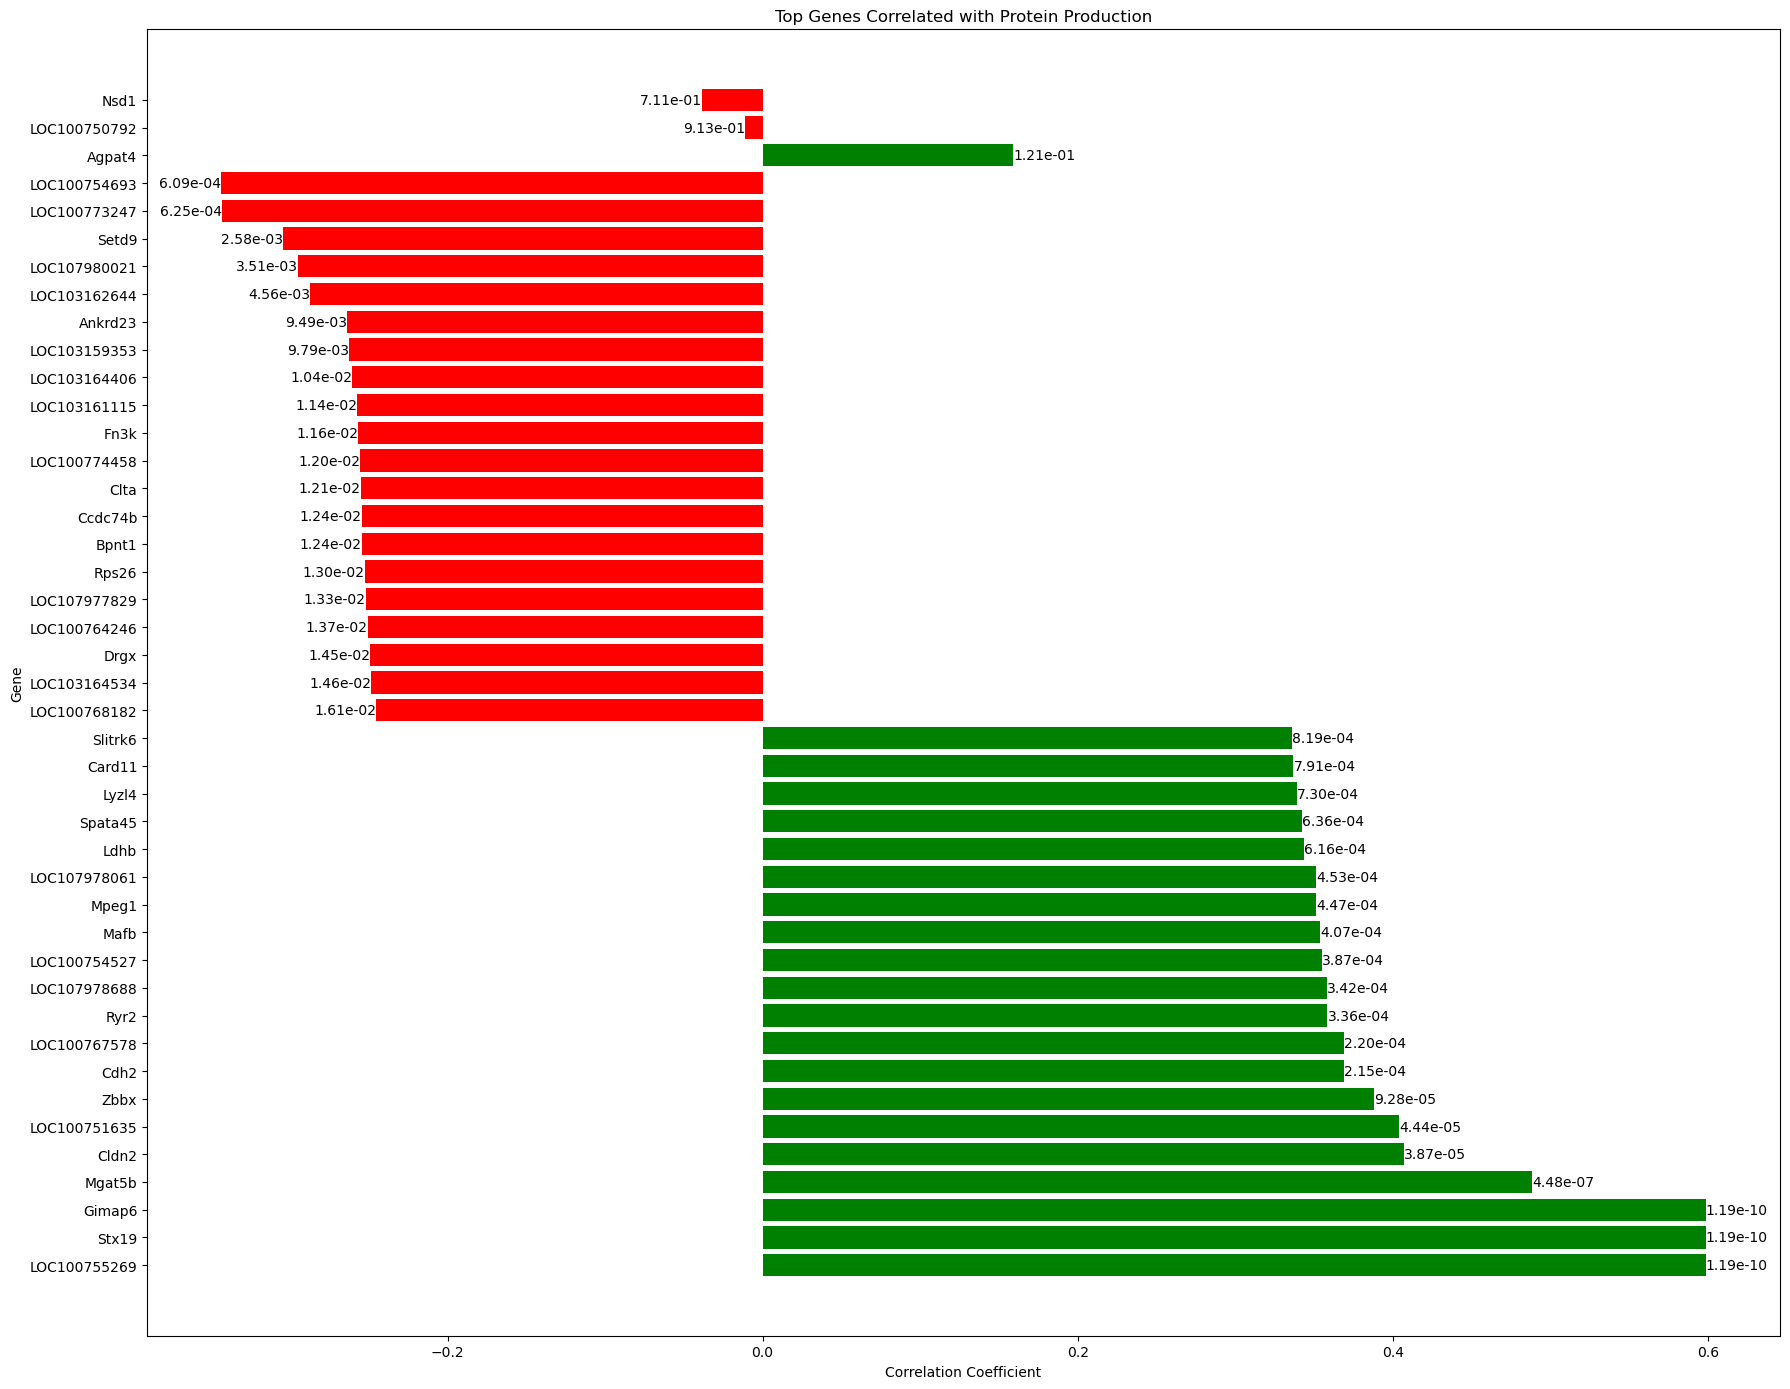

In [6]:
# Select top 10 positively and negatively correlated genes
selected_genes = pd.concat([correlation_df.head(20), correlation_df.tail(20)], ignore_index=True)

# Include additional genes if not already in the selected genes
additional_genes = ['Agpat4', 'LOC100750792', 'Nsd1']
for gene in additional_genes:
    if gene not in selected_genes['Gene'].values:
        gene_row = correlation_df[correlation_df['Gene'] == gene]
        if not gene_row.empty:
            selected_genes = pd.concat([selected_genes, gene_row], ignore_index=True)

# Visualize correlations using a bar plot with p-values
plt.figure(figsize=(18, 14))
bars = plt.barh(
    selected_genes['Gene'], 
    selected_genes['Correlation'], 
    color=['green' if corr > 0 else 'red' for corr in selected_genes['Correlation']]
)

# Annotate bars with p-values
for bar, p_value in zip(bars, selected_genes['P-Value']):
    plt.text(
        bar.get_width(),  # Position at the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically on the bar
        f'{p_value:.2e}',  # Format p-value in scientific notation
        va='center',  # Align vertically centered
        ha='left' if bar.get_width() > 0 else 'right'  # Adjust alignment for positive/negative bars
    )

plt.title('Top Genes Correlated with Protein Production')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()


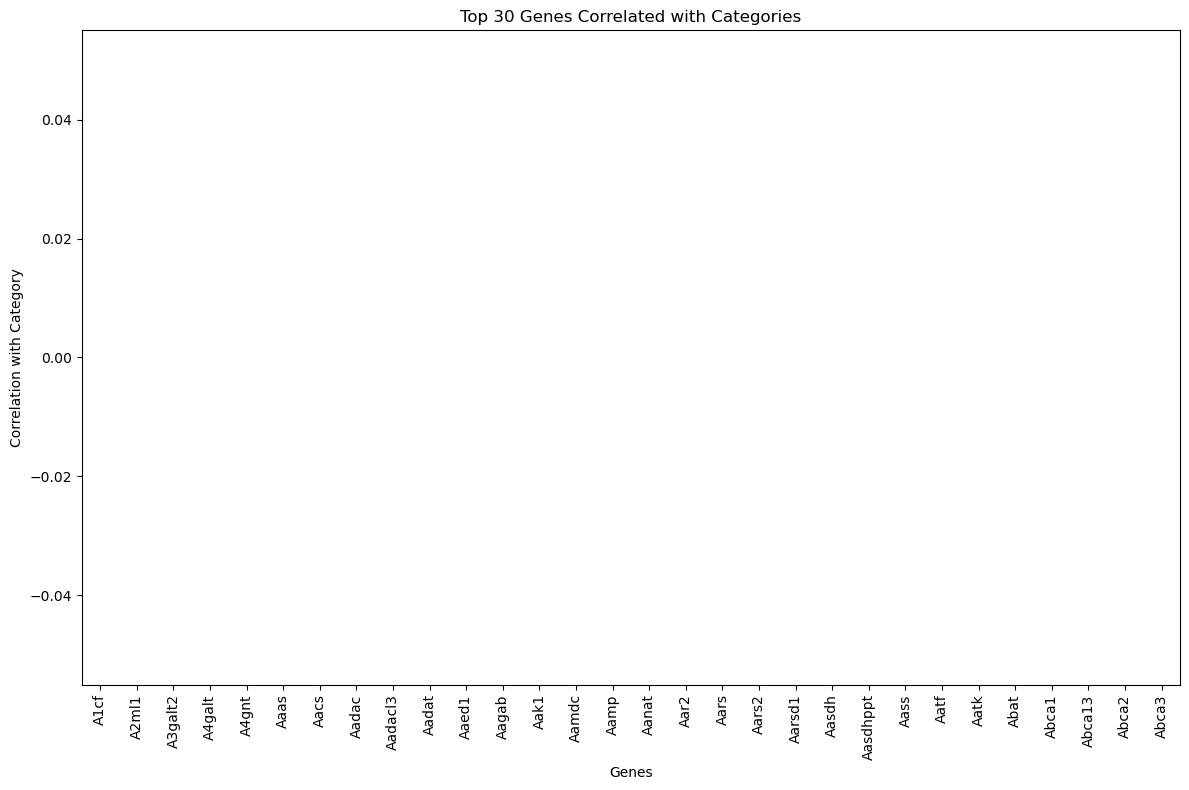

In [13]:
# Step 1: Drop the unnecessary column and prepare the data
filtered_data = combined_data.drop(columns=["Total_protein_microg"]).dropna(subset=['Category'])


# Separate gene TPM values and Category column
gene_data = combined_data.drop(columns=["Category"])
categories = combined_data["Category"]

# Step 2: Encode the Category column into numeric values
label_encoder = LabelEncoder()
numeric_categories = label_encoder.fit_transform(categories)

# Step 3: Compute correlations
correlation_with_category = gene_data.corrwith(pd.Series(numeric_categories))

# Step 4: Sort genes by absolute correlation
sorted_correlations = correlation_with_category.abs().sort_values(ascending=False)

# Select the top 30 genes with the highest correlation
top_genes = sorted_correlations.head(30)
top_genes_data = correlation_with_category[top_genes.index]

# Step 5: Visualize the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=top_genes_data.index, y=top_genes_data.values)
plt.xticks(rotation=90)
plt.xlabel("Genes")
plt.ylabel("Correlation with Category")
plt.title("Top 30 Genes Correlated with Categories")
plt.tight_layout()
plt.show()


In [21]:
filtered_data.reset_index(inplace=True,drop=True)

In [22]:
filtered_data

sample_ID  A1cf     A2ml1  A3galt2    A4galt     A4gnt       Aaas  \
0   P6975_138   0.0  0.000000      0.0  0.030636  0.070576  26.422721   
1   P6975_139   0.0  0.000000      0.0  0.060819  0.000000  31.630587   
2   P6975_140   0.0  0.000000      0.0  0.000000  0.000000  29.411086   
3   P6975_141   0.0  0.000000      0.0  0.000000  0.000000  31.972233   
4   P6975_142   0.0  0.000000      0.0  0.046190  0.000000  29.392032   
5   P6975_143   0.0  0.000000      0.0  0.000000  0.000000  28.825781   
6   P6975_144   0.0  0.000000      0.0  0.026203  0.000000  33.100773   
7   P6975_145   0.0  0.000000      0.0  0.000000  0.000000  25.692008   
8   P6975_146   0.0  0.000000      0.0  0.028855  0.000000  25.757159   
9   P6975_147   0.0  0.000000      0.0  0.000000  0.000000  30.407090   
10  P6975_148   0.0  0.000000      0.0  0.085127  0.000000  30.331869   
11  P6975_149   0.0  0.000000      0.0  0.000000  0.000000  37.245803   
12  P6975_150   0.0  0.000000      0.0  0.000000  0.000000  46.618244   
13  P6975_152   0.0  0.000000      0.0  0.053982  0.000000  39.454547   
14  P6975_153   0.0  0.000000      0.0  0.030513  0.070293  25.904312   
15  P6975_154   0.0  0.000000      0.0  0.000000  0.000000  23.601181   
16  P6975_155   0.0  0.000000      0.0  0.000000  0.000000  19.431126   
17  P6975_156   0.0  0.000000      0.0  0.000000  0.000000  26.701770   
18  P6975_157   0.0  0.000000      0.0  0.000000  0.000000  30.247362   
19  P6975_158   0.0  0.000000      0.0  0.025105  0.000000  24.863021   
20  P6975_159   0.0  0.000000      0.0  0.000000  0.000000  22.971920   
21  P6975_160   0.0  0.000000      0.0  0.000000  0.000000  33.981609   
22  P6975_161   0.0  0.000000      0.0  0.031165  0.000000  27.214826   
23  P6975_162   0.0  0.000000      0.0  0.000000  0.000000  33.716596   
24  P6975_163   0.0  0.000000      0.0  0.000000  0.000000  27.199177   
25  P6975_164   0.0  0.000000      0.0  0.059996  0.000000  34.808853   
26  P6975_165   0.0  0.000000      0.0  0.096454  0.071106  29.674652   
27  P6975_166   0.0  0.000000      0.0  0.000000  0.000000  37.485666   
28  P6975_167   0.0  0.000000      0.0  0.027093  0.000000  33.231568   
29  P6975_175   0.0  0.000000      0.0  0.028147  0.000000  32.658139   
30  P6975_192   0.0  0.000000      0.0  0.000000  0.000000  46.914633   
31  P6975_193   0.0  0.000000      0.0  0.169419  0.000000  25.957818   
32  P6975_194   0.0  0.014429      0.0  0.037419  0.000000  25.775097   
33  P6975_195   0.0  0.000000      0.0  0.090249  0.000000  25.081420   

         Aacs     Aadac  Aadacl3  ...      Zufsp       Zw10     Zwilch  \
0   13.279923  0.000000      0.0  ...   8.474118  18.987061  24.748412   
1   13.812603  0.000000      0.0  ...   6.845135  15.070007  15.134862   
2   12.456065  0.054368      0.0  ...   7.783150  18.592462  21.861442   
3   13.828540  0.150933      0.0  ...   5.925610  15.607849  12.747492   
4   13.062891  0.000000      0.0  ...   6.702395  16.906763  18.659460   
5   13.007481  0.048989      0.0  ...   5.725302  15.498258  15.744838   
6   12.544483  0.047131      0.0  ...   5.177426  15.437461  13.804529   
7   11.127475  0.052641      0.0  ...   7.496223  14.033129  15.545646   
8   11.857554  0.000000      0.0  ...   7.990708  19.377892  21.651122   
9   13.846062  0.053578      0.0  ...   8.536316  18.824704  22.893256   
10  12.087967  0.000000      0.0  ...   5.586091  15.226102  14.421318   
11  11.873332  0.000000      0.0  ...   5.306283  15.210830  12.680406   
12  20.057699  0.000000      0.0  ...   6.793487  21.319439  13.388198   
13  15.422397  0.000000      0.0  ...   6.274638  17.997563  14.829062   
14  11.808164  0.057169      0.0  ...   7.683162  15.858715  17.996975   
15  10.438404  0.055660      0.0  ...   7.296124  14.797757  18.870653   
16   9.743734  0.000000      0.0  ...   6.054593  12.167876  14.260291   
17  13.206682  0.165263      0.0  ...   6.613548  17.367988  19.546688   
18  14.053149  0.000000      0.0  ...   6.